In [1]:
cmd_line_run = False
if not cmd_line_run:
    %matplotlib inline
collab_mode = False

if collab_mode and not cmd_line_run:
    # set up tensorflow in collab
    %tensorflow_version 2.x
# imports
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

import warnings # This ignore all the warning messages
warnings.filterwarnings('ignore')

from random import randint
from os import path
import os
import time

print("Tensorflow version is", tf.__version__, ", device name", tf.test.gpu_device_name())

batch_size = 2048
image_size = (64, 64)
if not os.path.exists('./embedding'):
    os.makedirs('./embedding')

Tensorflow version is 2.0.0 , device name /device:GPU:0


(64, 64, 3) 0.0 0.99964094


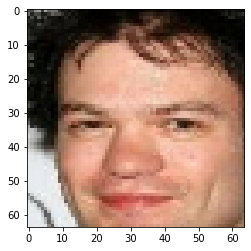

In [2]:
attributes_subset = [
        'Attractive', 'Bald', 'Bangs',
        'Big_Nose', 'Heavy_Makeup', 'Blond_Hair',
        'Male', 'Smiling', 'Young', 'Straight_Hair'
]

def prepare_embeddings_from_batch(batch, output_type=tf.float32, attributes_subset = None):
    imgs, attributes = batch
    
    if attributes_subset is not None:
        attributes = {key: attributes[key] for key in attributes if key in attributes_subset}
    embeddings = tf.stack(list(attributes.values()))
    embeddings = tf.transpose(embeddings)
    embeddings = tf.cast(embeddings, dtype=output_type)
    return imgs, embeddings

def process_image(img, image_shape):
    img = tf.cast(img, tf.float32)/127.5-1 # IMPORTANT, image's pixels are in the range <-1, 1>
    img = img[50:(218-50), 40:(178-40)] # crop
    img = tf.image.resize(img, image_shape)
    return img

def load_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img)
    return img

def convert_from_output_to_image(images):
    return tf.clip_by_value((images+1)/2, 0, 1)

def display_image_from_dataset(data):
    for batch in data.take(1):
        image, attributes = batch
        img_ = convert_from_output_to_image(image[0])
        plt.imshow(img_)
        print(img_.shape, np.min(img_), np.max(img_))

def save_generated_image(settings, epoch):
    save_dir = settings.generated_images_path
    if not path.exists(save_dir):
        os.makedirs(save_dir)
    name = path.join(save_dir,
                     'img_{}_{}.png'.format(epoch, get_time()))
    plt.savefig(name)


def show_images(images, epoch, settings, save_images=False, display_images=False):
    print("image pixels range", np.min(images), np.max(images), "std", np.std(images))
    num_of_images = min(10, images.shape[0])
    # (x, y=1)
    plt.figure(figsize=(num_of_images, 1))
    for i in range(num_of_images):
        plt.subplot(1, num_of_images, i + 1)
        img = images[i, :, :, :].numpy() #
        # img = convert_from_output_to_image(img) # images are already converted in gen_step
        # img = (img * 127.5 + 127.5).astype(np.uint8)
        plt.imshow(img)
        plt.axis('off')
    

    if save_images:
        save_generated_image(settings, epoch)
    if display_images and not cmd_line_run:
        plt.show()

def load_dataset(image_shape, preprocess_images=True, shuffle_size=500, seed=101, split=tfds.Split.TRAIN):
    dataset_name = 'celeb_a'
    data = tfds.load(dataset_name, split=split)\
               .shuffle(shuffle_size)
    # for each image return a tuple (image, attributes), ignore 'landmarks'
    if preprocess_images:
        data = data\
            .map(lambda x: (process_image(x['image'], image_shape), x['attributes']))
    else:
        data = data\
            .map(lambda x: (x['image'], x['attributes']))
    return data.batch(batch_size)
train_data = load_dataset(image_size)
test_data = load_dataset(image_size, split=tfds.Split.TEST)

train_count = 162770
test_count = 19962

display_image_from_dataset(train_data)

In [3]:
kernel_size = 2
strides = 2
initial_filters = 16
input_shape= (*image_size, 3)
outputs = len(attributes_subset) if attributes_subset is not None else 40
embedding_size = 128
epochs = 10

model_embedding = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters=initial_filters,
        kernel_size=kernel_size,
        strides=strides,
        input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    
    tf.keras.layers.Conv2D(
        filters=initial_filters*2,
        kernel_size=kernel_size,
        strides=strides),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    
    tf.keras.layers.Conv2D(
        filters=initial_filters*4,
        kernel_size=kernel_size,
        strides=strides),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    
    tf.keras.layers.Conv2D(
        filters=initial_filters*8,
        kernel_size=kernel_size,
        strides=strides*2),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(embedding_size)
], name='embedding')

model_all = tf.keras.Sequential([
    tf.keras.layers.Dense(outputs, activation='sigmoid', input_shape=(embedding_size, ))
], name='all')

model_embedding.summary()
model_all.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        208       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          82

In [4]:
def save_model_and_weights(model, name):
    # save model and its weights
    model_json = model.to_json()
    with open("./embedding/{}_structure.json".format(name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights('./embedding/{}_weights.h5'.format(name))
    
    print('saved model: {}'.format(name))

In [5]:
def train_step(embedding_model, sigmoids_model):
    loss_f = tf.keras.losses.BinaryCrossentropy()
    optimizer = tf.keras.optimizers.Adam(1e-4)
    
    def test(test_x, test_y):
        test_output = sigmoids_model(embedding_model(test_x))
        return loss_f(test_output, test_y)
    
    def train(data, test_data):
        val = []
        print_every_iter = 5
        time_sum = 0.0
        test_x, test_y = prepare_embeddings_from_batch(next(iter(test_data)), attributes_subset=attributes_subset)
        for epoch in range(epochs):
            iteration = 0
            for batch in data:
                s = time.time()
                x, y = prepare_embeddings_from_batch(batch, attributes_subset=attributes_subset)
                
                @tf.function
                def _train():
                    with tf.GradientTape() as tape:
                        embedding = embedding_model(x)
                        output = sigmoids_model(embedding)
                        train_loss = loss_f(output, y)

                    grads = tape.gradient(train_loss, 
                                          embedding_model.trainable_variables + sigmoids_model.trainable_variables)
                    optimizer.apply_gradients(zip(grads, 
                                                 embedding_model.trainable_variables + sigmoids_model.trainable_variables))
                    return train_loss
                train_loss = _train()
                e = time.time()
                time_sum += e-s
                if (iteration+1)%print_every_iter == 0:
                    progress = (int((iteration+1)*batch_size*100 / train_count))
                    iter_time = (time_sum/print_every_iter)
                    print('epoch ', epoch+1,'progress: ',progress,' %, time ',iter_time)
                    time_sum = 0.0
                iteration+=1
                
            
            test_loss = test(test_x, test_y)
            
            save_model_and_weights(embedding_model, 'embedding_10attr_changed_net')
            epoch_res = 'epoch {}/{}, loss {}, test_loss {}'.format(epoch+1, epochs, train_loss, test_loss)
            print(epoch_res)
            val.append(epoch_res)
        return val
            
    return train
        
train_f = train_step(model_embedding, model_all)
res = train_f(train_data, test_data)

with open('representation', 'w') as f:
    f.writelines(res)

epoch  1 progress:  6  %, time  1.3551134586334228
epoch  1 progress:  12  %, time  0.739394998550415
epoch  1 progress:  18  %, time  0.6147096157073975
epoch  1 progress:  25  %, time  0.6313878536224365
epoch  1 progress:  31  %, time  0.6275001525878906
epoch  1 progress:  37  %, time  0.7936123847961426
epoch  1 progress:  44  %, time  0.7564778804779053
epoch  1 progress:  50  %, time  0.6802363395690918
epoch  1 progress:  56  %, time  0.6926822662353516
epoch  1 progress:  62  %, time  0.6935555934906006
epoch  1 progress:  69  %, time  0.6633721828460694
epoch  1 progress:  75  %, time  0.6259775161743164
epoch  1 progress:  81  %, time  0.6556247234344482
epoch  1 progress:  88  %, time  0.6318241119384765
epoch  1 progress:  94  %, time  0.6863379001617431
epoch  1 progress:  100  %, time  0.6421751499176025
saved model: embedding_10attr_changed_net
epoch 1/10, loss 4.1574320793151855, test_loss 4.227690696716309
epoch  2 progress:  6  %, time  0.6813719272613525
epoch  2 pr

epoch  9 progress:  94  %, time  1.0318858623504639
epoch  9 progress:  100  %, time  0.8826215744018555
saved model: embedding_10attr_changed_net
epoch 9/10, loss 3.1760714054107666, test_loss 3.236891984939575
epoch  10 progress:  6  %, time  0.9448145389556885
epoch  10 progress:  12  %, time  0.9222382545471192
epoch  10 progress:  18  %, time  0.9725105285644531
epoch  10 progress:  25  %, time  0.8596037864685059
epoch  10 progress:  31  %, time  0.877708101272583
epoch  10 progress:  37  %, time  1.029103660583496
epoch  10 progress:  44  %, time  0.9160688400268555
epoch  10 progress:  50  %, time  0.9403282165527344
epoch  10 progress:  56  %, time  0.856281042098999
epoch  10 progress:  62  %, time  0.8481643199920654
epoch  10 progress:  69  %, time  0.8449550628662109
epoch  10 progress:  75  %, time  1.0220286846160889
epoch  10 progress:  81  %, time  1.5583725452423096
epoch  10 progress:  88  %, time  1.2729849815368652
epoch  10 progress:  94  %, time  1.26597142219543

In [6]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


In [7]:
test_iter = iter(test_data)
x, y = prepare_embeddings_from_batch(next(test_iter), attributes_subset=attributes_subset)
output = model_all(model_embedding(x)).numpy()
o = np.array([1 if x > .5 else 0 for x in output[0]], dtype=np.int8)
print(f1_m(output, y), recall_m(output, y))

tf.Tensor(0.63691133, shape=(), dtype=float32) tf.Tensor(0.75467527, shape=(), dtype=float32)


In [8]:
for batch in test_data:
    x, y = prepare_embeddings_from_batch(batch, attributes_subset=attributes_subset)
    output = model_all(model_embedding(x)).numpy()
    o = np.array([1 if x > .5 else 0 for x in output[0]], dtype=np.int8)
    print(f1_m(output, y), recall_m(output, y))

tf.Tensor(0.640122, shape=(), dtype=float32) tf.Tensor(0.7580257, shape=(), dtype=float32)
tf.Tensor(0.6452612, shape=(), dtype=float32) tf.Tensor(0.7538214, shape=(), dtype=float32)
tf.Tensor(0.6428267, shape=(), dtype=float32) tf.Tensor(0.75711995, shape=(), dtype=float32)
tf.Tensor(0.6461119, shape=(), dtype=float32) tf.Tensor(0.7525794, shape=(), dtype=float32)
tf.Tensor(0.64460814, shape=(), dtype=float32) tf.Tensor(0.7521504, shape=(), dtype=float32)
tf.Tensor(0.64496326, shape=(), dtype=float32) tf.Tensor(0.765527, shape=(), dtype=float32)
tf.Tensor(0.6430703, shape=(), dtype=float32) tf.Tensor(0.75657237, shape=(), dtype=float32)
tf.Tensor(0.6395409, shape=(), dtype=float32) tf.Tensor(0.74938875, shape=(), dtype=float32)
tf.Tensor(0.6471447, shape=(), dtype=float32) tf.Tensor(0.76352584, shape=(), dtype=float32)
tf.Tensor(0.63906133, shape=(), dtype=float32) tf.Tensor(0.7485853, shape=(), dtype=float32)


In [9]:
for batch in train_data:
    x, y = prepare_embeddings_from_batch(batch, attributes_subset=attributes_subset)
    output = model_all(model_embedding(x)).numpy()
    o = np.array([1 if x > .5 else 0 for x in output[0]], dtype=np.int8)
    print(f1_m(output, y), recall_m(output, y))

tf.Tensor(0.65194494, shape=(), dtype=float32) tf.Tensor(0.77441484, shape=(), dtype=float32)
tf.Tensor(0.64811194, shape=(), dtype=float32) tf.Tensor(0.782582, shape=(), dtype=float32)
tf.Tensor(0.64643544, shape=(), dtype=float32) tf.Tensor(0.7726444, shape=(), dtype=float32)
tf.Tensor(0.6515806, shape=(), dtype=float32) tf.Tensor(0.7753126, shape=(), dtype=float32)
tf.Tensor(0.6499065, shape=(), dtype=float32) tf.Tensor(0.7749646, shape=(), dtype=float32)
tf.Tensor(0.6570112, shape=(), dtype=float32) tf.Tensor(0.782921, shape=(), dtype=float32)
tf.Tensor(0.640918, shape=(), dtype=float32) tf.Tensor(0.76916754, shape=(), dtype=float32)
tf.Tensor(0.64877635, shape=(), dtype=float32) tf.Tensor(0.77798015, shape=(), dtype=float32)
tf.Tensor(0.6494262, shape=(), dtype=float32) tf.Tensor(0.77245873, shape=(), dtype=float32)
tf.Tensor(0.6495493, shape=(), dtype=float32) tf.Tensor(0.7770545, shape=(), dtype=float32)
tf.Tensor(0.6418312, shape=(), dtype=float32) tf.Tensor(0.7589543, shape=()